# Explore Bias

In this notebook the operators $T$ and $T^*$, and it's influence over the signals and noise are analysed. The original signal is attempted to be recovered simply with the pseudoinverse of $T^*T$ in the same way as the bias term and the initial guess are obtaied.

In [1]:
# Import Packages
import numpy as np
from torch.autograd import Variable
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# Import local model files
from FBRN.myfunc import Physics
from FBRN.myfunc import MyMatmul
from FBRN.main import FBRestNet
from FBRN.model import MyModel
from FBRN.myfunc import Export_hyper

from FBRN.proxop.hypercube import cardan
from FBRN.proxop.hyperslab import cardan_slab

## Create model

In [2]:
# Model parameters
params = {
    'N' : 2000,
    'k' : 50,
    'a' : 1,
    'r' : 1

}

In [3]:
model = FBRestNet(
    model_id = 'model_000_',
    dataset_folder = '../Datasets/',
    model_folder = '../outputs/models/',
    opt_hist_folder = '../outputs/opt_hist/',
    experimentation=Physics(params['N'],params['k'],params['a'],params['r']),
    nb_blocks=20,
    im_set="Set1",
    noise = 0.05,        
    constraint = 'cube',  
    train_size=10,
    val_size=2,
    batch_size=64,
    lr=3e-1, 
    nb_epochs=50,
    freq_val=1,
    loss_elt=True,
    save_signals=False,
    save_outputs=False,
    save_model=False,
    save_hist=True
    )

In [4]:
# Generate dataset
train_set, val_set = model.CreateDataSet()

## Prepare signal

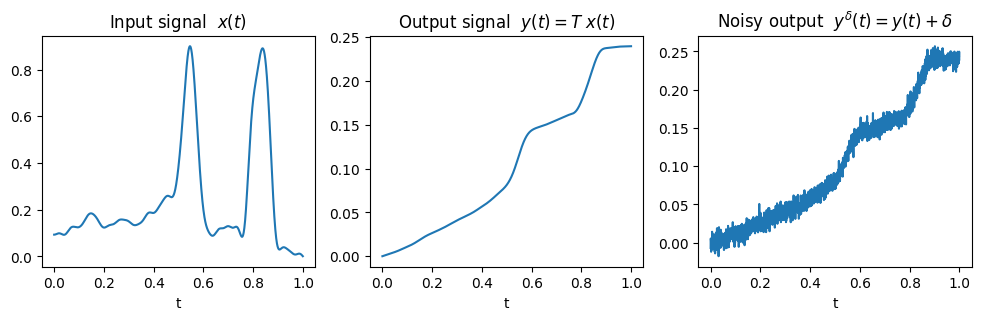

In [8]:
# Select one signal
signal_id = 1
[y,x] = val_set.dataset[signal_id:signal_id+1]
x_true = Variable(x, requires_grad=False)
x_bias = Variable(y, requires_grad=False)

# Input signal in the finite elements basis
test_signal_coeff = np.array(x_true[0,0])
test_signal_elt = torch.Tensor(model.physics.basis.T @ test_signal_coeff)

# Output signal with noise
y =  model.physics.Compute(test_signal_elt)
noise_std_dev = model.noise * np.sqrt((torch.sum(y**2)).item() )/np.sqrt(params['N'])
noise = torch.randn(test_signal_elt.shape) * noise_std_dev
y_noisy = model.physics.Compute(test_signal_elt) + noise

t = np.linspace(0,(params['N']-1)/params['N'],params['N'])
fig, ax = plt.subplots(1,3, figsize=(12,3))
ax[0].plot(t, model.model.Layers[0].Pelt(x_true).numpy()[0,0])
ax[0].set_title(r'Input signal  $x(t)$')
ax[0].set_xlabel('t')
ax[1].plot(t, y)
ax[1].set_title(r'Output signal  $y(t)=T\;x(t)$')
ax[1].set_xlabel('t')
ax[2].plot(t, y_noisy)
ax[2].set_title(r'Noisy output  $y^{\delta}(t)=y(t) + \delta$')
ax[2].set_xlabel('t')
plt.show()

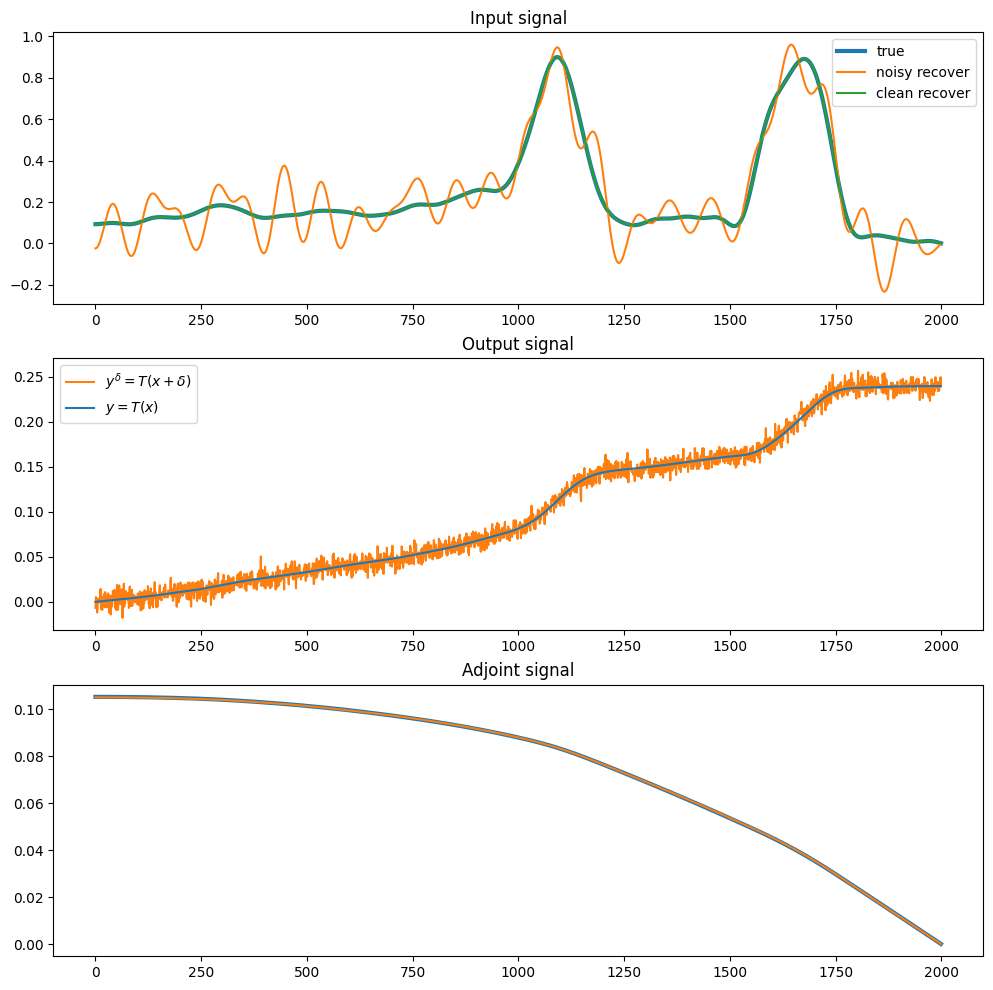

In [9]:

y_noisy_adj = model.physics.BasisChangeInv(model.physics.ComputeAdjoint(y_noisy))
y_adj = model.physics.BasisChangeInv(model.physics.ComputeAdjoint(y))

# T*T inverse
inv      = np.diag(model.physics.eigm**(2*model.physics.a))
tTTinv   = MyMatmul(inv)
x_hat_noisy   = tTTinv(torch.FloatTensor(np.array(model.physics.ComputeAdjoint(y_noisy))))
x_hat   = tTTinv(torch.FloatTensor(np.array(model.physics.ComputeAdjoint(y))))

im, ax = plt.subplots(3,1, figsize=(12,12))
ax[0].plot(test_signal_elt, label='true', linewidth=3)
ax[0].plot(model.physics.BasisChangeInv(x_hat_noisy), label='noisy recover')
ax[0].plot(model.physics.BasisChangeInv(x_hat), label='clean recover')
ax[0].legend()
ax[0].set_title('Input signal')

ax[1].plot(y_noisy, label='$y^{\delta}=T(x+\delta)$', color='C1')
ax[1].plot(y, label='$y=T(x)$', color='C0')
ax[1].legend()
ax[1].set_title('Output signal')

ax[2].plot(y_adj,linewidth=3)
ax[2].plot(y_noisy_adj)
ax[2].set_title('Adjoint signal')
plt.show()

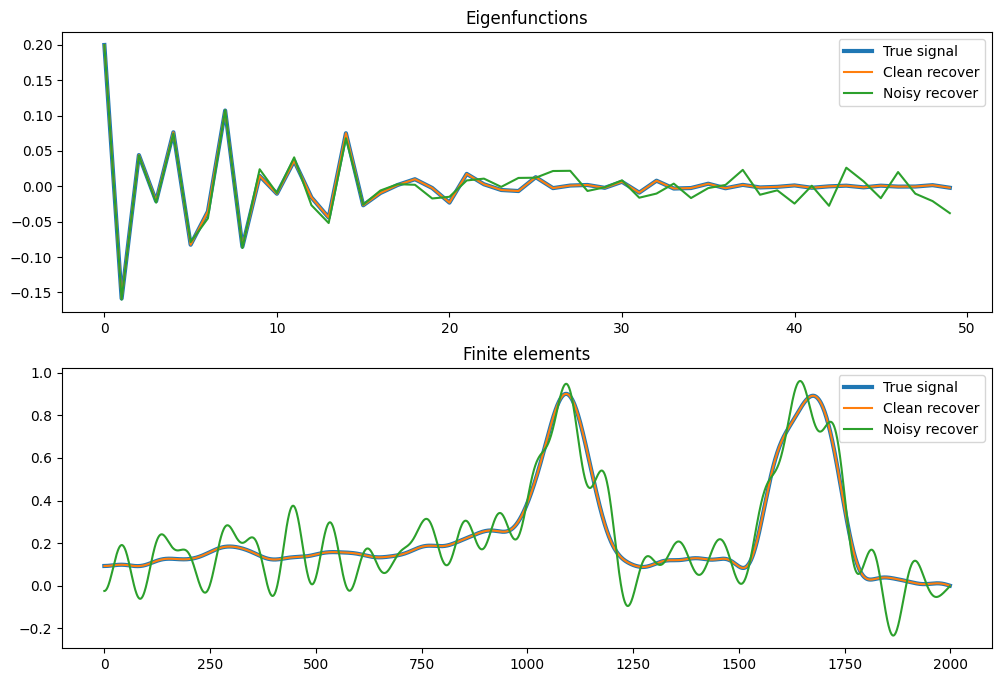

In [10]:
test_signal_eig = x_hat #model.physics.BasisChange(test_signal_elt)
test_signal_eig_noisy = x_hat_noisy
test_signal_elt_recover = model.physics.BasisChangeInv(test_signal_eig)
test_signal_elt_noisy_recover = model.physics.BasisChangeInv(test_signal_eig_noisy)

fig,ax = plt.subplots(2,1, figsize=(12,8))
ax[0].plot(test_signal_coeff, label='True signal', linewidth=3)
ax[0].plot(test_signal_eig, label='Clean recover')
ax[0].plot(test_signal_eig_noisy, label='Noisy recover')
ax[0].set_title('Eigenfunctions')
ax[0].legend()

ax[1].plot(test_signal_elt, label='True signal', linewidth=3)
ax[1].plot(test_signal_elt_recover, label='Clean recover')
ax[1].plot(test_signal_elt_noisy_recover, label='Noisy recover')
ax[1].set_title('Finite elements')
ax[1].legend()
plt.show()

# T operator in finite elements space

In [11]:
from scipy.special import gamma

In [12]:
x_true_elt = model.model.Layers[0].Pelt(x_true).numpy()[0,0]
y_true_elt = y

In [13]:
# T operator as defined in the paper
a = params['a']
h = 1/(params['N']) # correction to the paper, where h=1/(N-1).

g = gamma(a)

Ta = np.zeros((params['N'],params['N']))

for i in range(params['N']):
    for j in range(params['N']):
        if j<i:
            Ta[i,j]=h**a/(2*g*a) * ((i-j+1)**a-(i-j-1)**a)
        if j==0 and i!=0:
            Ta[i,j]=h**a/(2*g*a) * ((i)**a - (i-1)**a)
        if j==i and i!=0:
            Ta[i,j]=h**a/(2*g*a)
        if i==j and i==0:
            Ta[i,j]=0
        if j>i:
            Ta[i,j]=0

Tadj = np.zeros((params['N'],params['N']))

# for i in range(params['N']):
#     for j in range(params['N']):
#         if j>i and j!=(params['N']-1):
#             Tadj[i,j]=h**(a+1)/(2*g*(a+1)) * ((j-i+1)**(a+1)-(j-i-1)**(a+1))
#         if j==(params['N']-1) and i!=j:
#             Tadj[i,j]=h**(a+1)/(2*g*(a+1)) * ((j-i)**(a+1) - (j-i-1)**(a+1))
#         if j==i and i!=(params['N']-1):
#             Tadj[i,j]=h**(a+1)/(2*g*(a+1))
#         if i==j and i==(params['N']-1):
#             Tadj[i,j]=0
#         if j<i:
#             Tadj[i,j]=0

for i in range(params['N']):
    for j in range(params['N']):
        if j>i and j!=(params['N']-1):
            Tadj[i,j]=h**(a)/(2*g*(a)) * ((j-i+1)**(a)-(j-i-1)**(a))
        if j==(params['N']-1) and i!=j:
            Tadj[i,j]=h**(a)/(2*g*(a)) * (2* (j-i+1)**(a) - (j-i)**(a) - (j-i-1)**a)
        if j==i and i!=(params['N']-1):
            Tadj[i,j]=h**(a)/(2*g*(a))
        if i==j and i==(params['N']-1):
            Tadj[i,j]=h**(a)/(g*(a))
        if j<i:
            Tadj[i,j]=0

[]

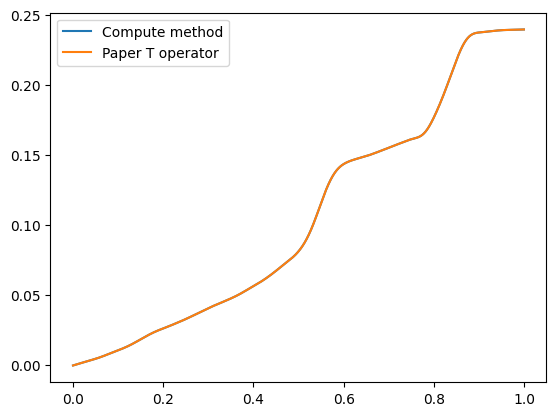

In [14]:
plt.plot(t, y, label='Compute method')
plt.plot(t, Ta.dot(x_true_elt), label='Paper T operator')
plt.legend()
plt.plot()

In [15]:
yy = Tadj.dot(y)
print(y.shape)
print(yy.shape)

torch.Size([2000])
(2000,)


[]

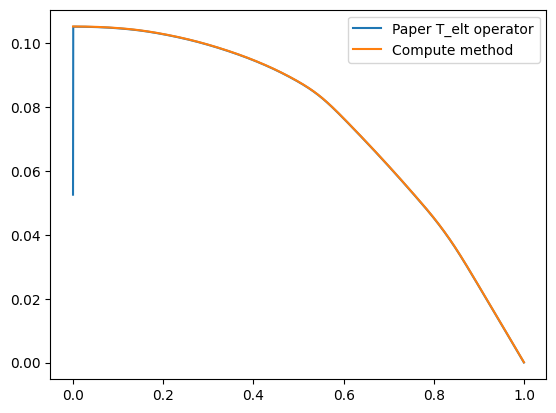

In [26]:
plt.plot(t, (Ta.T).dot(Ta.dot(x_true_elt)), label='Paper T_elt operator')
plt.plot(t, yy, label='Compute method')
plt.legend()
plt.plot()

In [27]:
print(np.around(Tadj[-10:,-10:]*1e2, 2))
print()
print(np.around(Ta[:10,:10]*1e2, 2))

[[0.02 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.08]
 [0.   0.02 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.08]
 [0.   0.   0.02 0.05 0.05 0.05 0.05 0.05 0.05 0.08]
 [0.   0.   0.   0.02 0.05 0.05 0.05 0.05 0.05 0.08]
 [0.   0.   0.   0.   0.02 0.05 0.05 0.05 0.05 0.08]
 [0.   0.   0.   0.   0.   0.02 0.05 0.05 0.05 0.08]
 [0.   0.   0.   0.   0.   0.   0.02 0.05 0.05 0.08]
 [0.   0.   0.   0.   0.   0.   0.   0.02 0.05 0.08]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.02 0.08]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.05]]

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.02 0.02 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.02 0.05 0.02 0.   0.   0.   0.   0.   0.   0.  ]
 [0.02 0.05 0.05 0.02 0.   0.   0.   0.   0.   0.  ]
 [0.02 0.05 0.05 0.05 0.02 0.   0.   0.   0.   0.  ]
 [0.02 0.05 0.05 0.05 0.05 0.02 0.   0.   0.   0.  ]
 [0.02 0.05 0.05 0.05 0.05 0.05 0.02 0.   0.   0.  ]
 [0.02 0.05 0.05 0.05 0.05 0.05 0.05 0.02 0.   0.  ]
 [0.02 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.

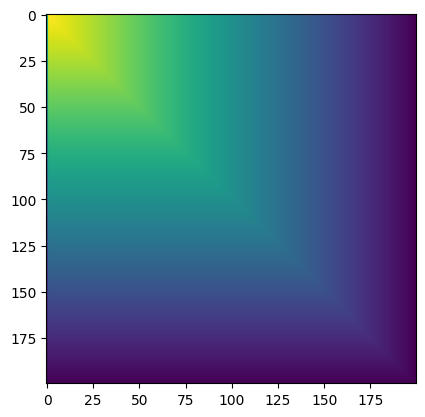

In [34]:
plt.imshow((Tadj.dot(Ta))[::10,::10])
plt.show()

[]

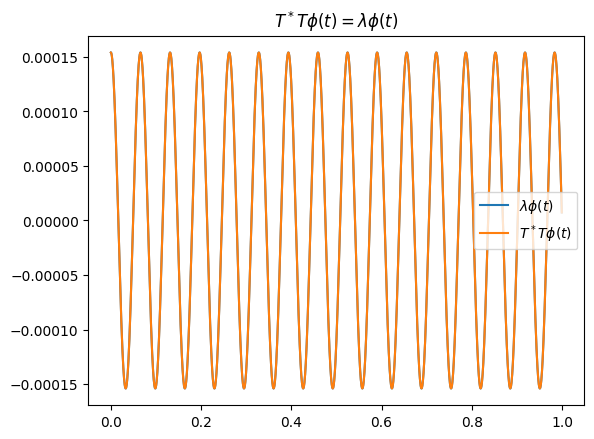

In [35]:
idx = 30
eig_func = model.physics.basis[idx,:]
eig_val  = (1/model.physics.eigm**(2*a))[idx]
plt.plot(t,eig_func*eig_val, label=r'$\lambda \phi(t)$')
plt.plot(t,Tadj.dot(Ta).dot(eig_func), label=r'$T^*T\phi(t)$')
plt.title(r'$T^*T\phi(t)=\lambda \phi(t)$')
plt.legend()
plt.plot()

